
# 🌍 Global Education & Development Analysis — Colab Notebook

This end-to-end notebook downloads World Bank indicators, performs exploratory data analysis (EDA), engineers features, and trains a predictive model for education outcomes.

> **How to use in Colab:**  
> 1. Upload this notebook to Google Colab.  
> 2. Run each cell in order.  
> 3. Change the **TARGET** indicator in the **Configuration** cell if desired.


In [1]:

# If running in Colab, install dependencies
!pip -q install wbgapi pandas numpy scikit-learn pyyaml matplotlib plotly statsmodels xgboost lightgbm joblib


In [14]:

import os, yaml, math, textwrap, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wbgapi as wb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

warnings.filterwarnings('ignore')

# Project paths (Colab-friendly)
ROOT = Path('/content/global-edu-dev')
DATA = ROOT / 'data'
RAW = DATA / 'raw'
PROC = DATA / 'processed'
MODELS = ROOT / 'models'
CFG = ROOT / 'configs'
for p in [RAW, PROC, MODELS, CFG]:
    p.mkdir(parents=True, exist_ok=True)

print('Project root:', ROOT)


Project root: /content/global-edu-dev


In [16]:

# =====================
# Configuration
# =====================
START_YEAR, END_YEAR = 2000, 2024

INDICATORS = {
    # Targets (education outcomes) — choose one as TARGET below
    'targets': [
        'SE.PRM.CMPT.ZS',     # Primary completion rate
        'SE.SEC.ENRR',        # Secondary enrollment (gross)
        'SE.ADT.LITR.ZS',     # Adult literacy
        'SE.XPD.TOTL.GD.ZS'   # Govt education exp (% GDP)
    ],
    # Socio-economic features
    'features': [
        'NY.GDP.PCAP.CD',     # GDP per capita (current US$)
        'SI.POV.DDAY',        # Poverty headcount ratio at $2.15/day
        'SL.UEM.TOTL.ZS',     # Unemployment (%)
        'IT.NET.USER.ZS',     # Internet users (%)
        'EG.ELC.ACCS.ZS',     # Electricity access (%)
        'SP.URB.TOTL.IN.ZS',  # Urban population (%)
        'SP.DYN.LE00.IN',     # Life expectancy
        'SH.DYN.MORT',        # Under-5 mortality
        'SH.XPD.CHEX.PC.CD',  # Health expenditure per capita
        'SP.POP.TOTL',        # Population
        'EN.ATM.CO2E.PC'      # CO2 per capita
    ]
}

# Choose your modeling target here
TARGET = 'SE.SEC.ENRR'  # Change to any in INDICATORS['targets']

# Save as YAML (for parity with repo structure)
with open(CFG / 'indicators.yaml', 'w') as f:
    yaml.safe_dump(INDICATORS, f)

print('Target:', TARGET)
print('Indicators saved to:', CFG / 'indicators.yaml')


Target: SE.SEC.ENRR
Indicators saved to: /content/global-edu-dev/configs/indicators.yaml


In [17]:

def fetch_world_bank(indicator_list, start=2000, end=2024):
    df = wb.data.DataFrame(indicator_list,
                           time=range(start, end+1),
                           labels=True, numericTimeKeys=True)
    df = df.reset_index().rename(columns={'economy':'country_code','Time':'year'})
    # Country metadata
    meta = wb.economy.DataFrame().reset_index()[['id','name','region','incomeLevel','lendingType']]
    meta = meta.rename(columns={'id':'country_code','name':'country','incomeLevel':'income_group'})
    out = df.merge(meta, on='country_code', how='left')
    return out

indicators = list(set(INDICATORS['targets'] + INDICATORS['features']))
print(f'Fetching {len(indicators)} indicators from {START_YEAR}-{END_YEAR} ...')
wb_df = fetch_world_bank(indicators, START_YEAR, END_YEAR)

raw_csv = RAW / 'wb_indicators.csv'
wb_df.to_csv(raw_csv, index=False)
print('Saved:', raw_csv)
wb_df.head()


Fetching 15 indicators from 2000-2024 ...
Saved: /content/global-edu-dev/data/raw/wb_indicators.csv


,country_code,series,Country,Series,2000,2001,2002,2003,2004,2005,...,2019,2020,2021,2022,2023,2024,country,region,income_group,lendingType
0,ZWE,SE.PRM.CMPT.ZS,Zimbabwe,"Primary completion rate, total (% of relevant ...",NaN,100.797401,95.241722,93.712601,NaN,NaN,...,86.833763,88.343367,83.033886,83.198409,85.202932,85.960763,Zimbabwe,SSF,LMC,IDB
1,ZMB,SE.PRM.CMPT.ZS,Zambia,"Primary completion rate, total (% of relevant ...",60.372318,NaN,59.738880,NaN,70.450737,81.793213,...,NaN,NaN,NaN,NaN,NaN,NaN,Zambia,SSF,LMC,IDX
2,YEM,SE.PRM.CMPT.ZS,"Yemen, Rep.","Primary completion rate, total (% of relevant ...",NaN,51.218262,50.851898,53.914742,53.465710,53.487560,...,NaN,NaN,NaN,NaN,NaN,NaN,"Yemen, Rep.",MEA,LIC,IDX
3,PSE,SE.PRM.CMPT.ZS,West Bank and Gaza,"Primary completion rate, total (% of relevant ...",93.399239,96.231583,94.660202,101.068321,94.770271,97.556023,...,95.103170,98.274574,94.200071,93.766356,91.169516,NaN,West Bank and Gaza,MEA,LMC,LNX
4,VIR,SE.PRM.CMPT.ZS,Virgin Islands (U.S.),"Primary completion rate, total (% of relevant ...",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Virgin Islands (U.S.),LCN,HIC,LNX


In [18]:
import wbgapi as wb
import pandas as pd

indicators = list(set(INDICATORS["targets"] + INDICATORS["features"]))

rows = []
for rec in wb.data.fetch(indicators, time=range(START_YEAR, END_YEAR+1), numericTimeKeys=True):
    # some versions use 'series', others 'indicator', and some embed the code key directly
    code = rec.get("indicator") or rec.get("series")
    val = rec.get("value")
    if code is None:
        # try to discover the indicator code key
        code_keys = [k for k in rec.keys() if k not in {"economy","time","value","decimals","obs_status","footnote"} and not k.startswith("_")]
        if code_keys:
            code = code_keys[0]
            val = rec.get("value", rec.get(code))
    rows.append({
        "country_code": rec["economy"],
        "series": code,
        "year": rec["time"],
        "value": val
    })

long_df = pd.DataFrame(rows)
wide = long_df.pivot_table(index=["country_code","year"], columns="series", values="value").reset_index()

meta = wb.economy.DataFrame(labels=True).reset_index()[["id","name","region","incomeLevel","lendingType"]]
meta = meta.rename(columns={"id":"country_code","name":"country","incomeLevel":"income_group"})
wb_df = wide.merge(meta, on="country_code", how="left")

print("Fixed shape:", wb_df.shape)
print("Years:", int(wb_df["year"].min()), "→", int(wb_df["year"].max()))
print("Countries:", wb_df["country"].nunique())
wb_df.head()


Fixed shape: (6625, 20)
Years: 2000 → 2024
Countries: 265


,country_code,year,EG.ELC.ACCS.ZS,IT.NET.USER.ZS,NY.GDP.PCAP.CD,SE.ADT.LITR.ZS,SE.PRM.CMPT.ZS,SE.SEC.ENRR,SE.XPD.TOTL.GD.ZS,SH.DYN.MORT,SH.XPD.CHEX.PC.CD,SI.POV.DDAY,SL.UEM.TOTL.ZS,SP.DYN.LE00.IN,SP.POP.TOTL,SP.URB.TOTL.IN.ZS,country,region,income_group,lendingType
0,ABW,2000,91.7,15.4428,20681.023027,97.290001,NaN,NaN,4.71468,NaN,NaN,NaN,NaN,72.939,90588.0,46.717,Aruba,Latin America & Caribbean,High income,Not classified
1,ABW,2001,100.0,17.1000,20740.132583,NaN,88.127541,97.556534,4.79898,NaN,NaN,NaN,NaN,73.044,91439.0,46.339,Aruba,Latin America & Caribbean,High income,Not classified
2,ABW,2002,100.0,18.8000,21307.248251,NaN,98.832970,100.163063,4.87220,NaN,NaN,NaN,NaN,73.135,92074.0,45.972,Aruba,Latin America & Caribbean,High income,Not classified
3,ABW,2003,100.0,20.8000,21949.485996,NaN,97.024673,101.929070,NaN,NaN,NaN,NaN,NaN,73.236,93128.0,45.606,Aruba,Latin America & Caribbean,High income,Not classified
4,ABW,2004,100.0,23.0000,23700.631990,NaN,95.470139,100.940941,4.35699,NaN,NaN,NaN,NaN,73.223,95138.0,45.240,Aruba,Latin America & Caribbean,High income,Not classified


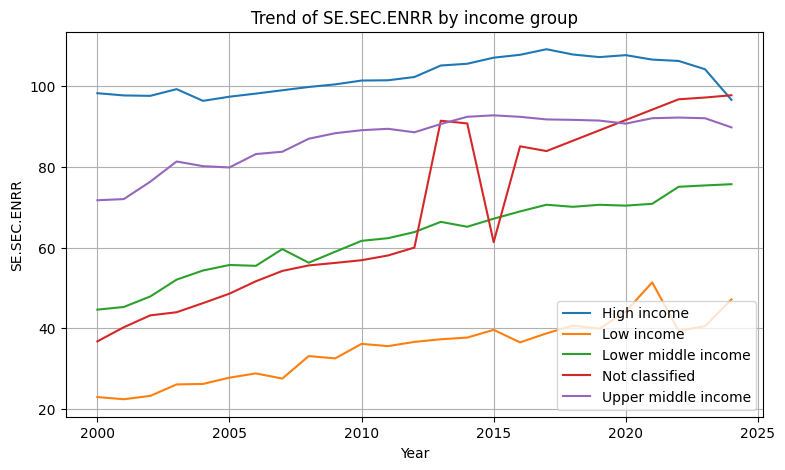

In [22]:

# Aggregate mean by year & income group
agg = (wb_df[['year','income_group', TARGET]]
       .dropna()
       .groupby(['year','income_group'], as_index=False)
       .mean())

plt.figure(figsize=(9,5))
for grp, gdf in agg.groupby('income_group'):
    plt.plot(gdf['year'], gdf[TARGET], label=str(grp))
plt.title(f'Trend of {TARGET} by income group')
plt.xlabel('Year'); plt.ylabel(TARGET); plt.legend(); plt.grid(True); plt.show()


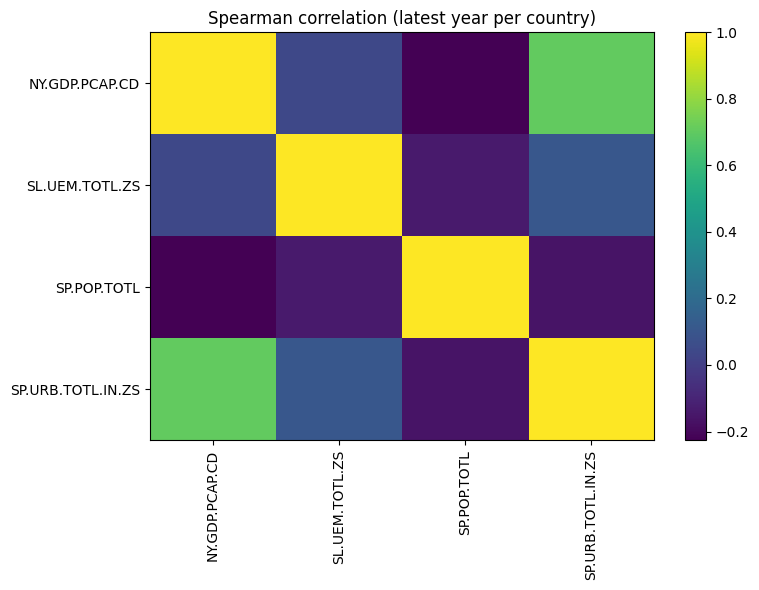

In [25]:

# # Pick most recent year per country to avoid over-weighting big countries over many years
# latest = wb_df.sort_values('year').groupby('country_code').tail(1)
# num_cols = [c for c in value_cols if latest[c].dtype != 'O']
# corr = latest[num_cols].corr(method='spearman')

# plt.figure(figsize=(8,6))
# plt.imshow(corr, aspect='auto')
# plt.colorbar(); plt.title('Spearman correlation (latest year per country)')
# plt.xticks(range(len(num_cols)), num_cols, rotation=90)
# plt.yticks(range(len(num_cols)), num_cols)
# plt.tight_layout(); plt.show()


# --- Robust correlation setup (drop this in before your corr plot) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Columns that are NOT indicator values
meta_cols = [c for c in ["country_code","country","region","income_group","lendingType","year"] if c in wb_df.columns]

# All candidate indicator columns (after your wide->tidy fix these are the WB codes)
value_cols = [c for c in wb_df.columns if c not in meta_cols]

# Take most recent year per country
latest = wb_df.sort_values("year").groupby("country_code", as_index=False).tail(1)

# Keep only numeric versions of those value columns
num_df = latest[value_cols].apply(pd.to_numeric, errors="coerce")

# Optional: keep columns with enough data & some variance
min_non_null_frac = 0.6
keep_cols = num_df.columns[num_df.notna().mean() >= min_non_null_frac]
num_df = num_df[keep_cols]
num_df = num_df.loc[:, num_df.nunique(dropna=True) > 1]  # drop constant cols

# If there are many indicators, you can cap for readability (optional)
# top by non-null count:
# topK = 30
# nn = num_df.notna().sum().sort_values(ascending=False)
# num_df = num_df[nn.index[:topK]]

# Compute Spearman correlation
corr = num_df.corr(method="spearman")

plt.figure(figsize=(max(8, 0.35*len(num_df.columns)), max(6, 0.35*len(num_df.columns))))
plt.imshow(corr, aspect="auto")
plt.colorbar(); plt.title("Spearman correlation (latest year per country)")
plt.xticks(range(len(num_df.columns)), num_df.columns, rotation=90)
plt.yticks(range(len(num_df.columns)), num_df.columns)
plt.tight_layout(); plt.show()


In [26]:

def engineer_features(df: pd.DataFrame, target: str) -> pd.DataFrame:
    df = df.sort_values(['country_code','year']).copy()
    feature_cols = [c for c in df.columns if c not in ['country_code','country','region','income_group','lendingType','year']]
    # Lags for all numeric features (1-year)
    for col in feature_cols:
        df[f'{col}_lag1'] = df.groupby('country_code')[col].shift(1)

    # Log transform GDP per capita (numeric safe)
    if 'NY.GDP.PCAP.CD' in df.columns:
        df['log_gdp_pc'] = np.log1p(df['NY.GDP.PCAP.CD'])

    # Keep rows with target observed
    keep = df.dropna(subset=[target])
    return keep

panel = engineer_features(wb_df, TARGET)
proc_path = PROC / 'wb_panel.parquet'
panel.to_parquet(proc_path, index=False)
print('Processed panel saved to:', proc_path)
panel.head()


Processed panel saved to: /content/global-edu-dev/data/processed/wb_panel.parquet


,country_code,year,EG.ELC.ACCS.ZS,IT.NET.USER.ZS,NY.GDP.PCAP.CD,SE.ADT.LITR.ZS,SE.PRM.CMPT.ZS,SE.SEC.ENRR,SE.XPD.TOTL.GD.ZS,SH.DYN.MORT,...,SE.SEC.ENRR_lag1,SE.XPD.TOTL.GD.ZS_lag1,SH.DYN.MORT_lag1,SH.XPD.CHEX.PC.CD_lag1,SI.POV.DDAY_lag1,SL.UEM.TOTL.ZS_lag1,SP.DYN.LE00.IN_lag1,SP.POP.TOTL_lag1,SP.URB.TOTL.IN.ZS_lag1,log_gdp_pc
1,ABW,2001,100.0,17.1,20740.132583,NaN,88.127541,97.556534,4.79898,NaN,...,NaN,4.71468,NaN,NaN,NaN,NaN,72.939,90588.0,46.717,9.939874
2,ABW,2002,100.0,18.8,21307.248251,NaN,98.832970,100.163063,4.87220,NaN,...,97.556534,4.79898,NaN,NaN,NaN,NaN,73.044,91439.0,46.339,9.966850
3,ABW,2003,100.0,20.8,21949.485996,NaN,97.024673,101.929070,NaN,NaN,...,100.163063,4.87220,NaN,NaN,NaN,NaN,73.135,92074.0,45.972,9.996545
4,ABW,2004,100.0,23.0,23700.631990,NaN,95.470139,100.940941,4.35699,NaN,...,101.929070,NaN,NaN,NaN,NaN,NaN,73.236,93128.0,45.606,10.073299
5,ABW,2005,100.0,25.4,24171.837133,NaN,94.429352,99.205353,4.62322,NaN,...,100.940941,4.35699,NaN,NaN,NaN,NaN,73.223,95138.0,45.240,10.092985


In [27]:

from sklearn.base import clone

cat_cols = ['region','income_group','lendingType']
drop_cols = ['country_code','country','year'] + cat_cols + [TARGET]
num_cols = [c for c in panel.columns if c not in drop_cols and panel[c].dtype != 'O']

X = panel[num_cols + cat_cols].copy()
y = panel[TARGET].copy()
groups = panel['country_code']

pre = ColumnTransformer([
    ('num', Pipeline([('impute', SimpleImputer(strategy='median')),
                      ('scale', StandardScaler())]), num_cols),
    ('cat', Pipeline([('impute', SimpleImputer(strategy='most_frequent')),
                      ('onehot', OneHotEncoder(handle_unknown='ignore'))]), cat_cols)
])

model = XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42
)

pipe = Pipeline([('pre', pre), ('model', model)])

gkf = GroupKFold(n_splits=5)
r2s, maes = [], []

for fold, (tr, va) in enumerate(gkf.split(X, y, groups)):
    pipe_fold = clone(pipe)
    pipe_fold.fit(X.iloc[tr], y.iloc[tr])
    pred = pipe_fold.predict(X.iloc[va])
    r2 = r2_score(y.iloc[va], pred)
    mae = mean_absolute_error(y.iloc[va], pred)
    r2s.append(r2); maes.append(mae)
    print(f'Fold {fold}: R2={r2:.3f} | MAE={mae:.2f}')

print(f'\nCV | R2={np.mean(r2s):.3f}±{np.std(r2s):.3f} | MAE={np.mean(maes):.2f}')


Fold 0: R2=0.938 | MAE=3.56
Fold 1: R2=0.933 | MAE=4.16
Fold 2: R2=0.959 | MAE=3.37
Fold 3: R2=0.950 | MAE=3.71
Fold 4: R2=0.909 | MAE=4.15

CV | R2=0.938±0.017 | MAE=3.79


SE.SEC.ENRR_lag1          0.583720
SH.DYN.MORT               0.072542
EG.ELC.ACCS.ZS            0.047720
SE.PRM.CMPT.ZS            0.029043
NY.GDP.PCAP.CD            0.019596
NY.GDP.PCAP.CD_lag1       0.011905
SP.URB.TOTL.IN.ZS         0.008873
IT.NET.USER.ZS            0.006083
SP.POP.TOTL_lag1          0.005391
SH.XPD.CHEX.PC.CD         0.005219
SP.POP.TOTL               0.005145
SE.PRM.CMPT.ZS_lag1       0.004207
SP.URB.TOTL.IN.ZS_lag1    0.003921
SP.DYN.LE00.IN            0.003901
SE.XPD.TOTL.GD.ZS         0.003828
dtype: float64


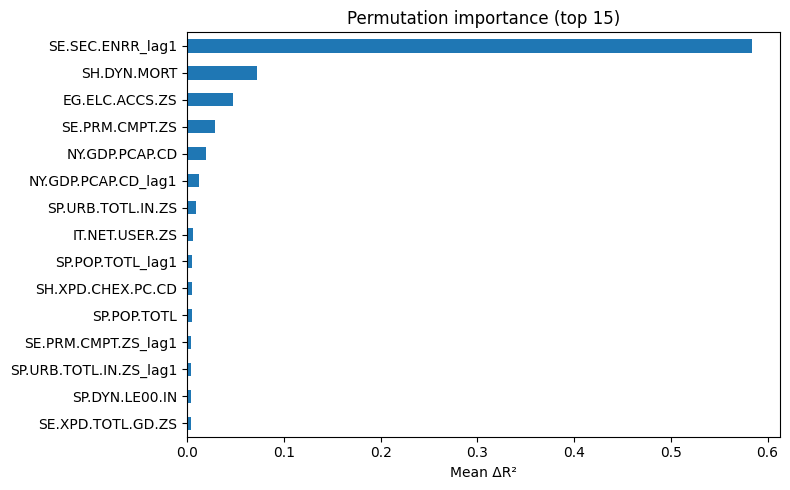

In [28]:

pipe.fit(X, y)

# Permutation importance on a held-out sample (to save time, use 500 random rows if large)
np.random.seed(42)
sample_idx = np.random.choice(len(X), size=min(500, len(X)), replace=False)
result = permutation_importance(pipe, X.iloc[sample_idx], y.iloc[sample_idx], n_repeats=5, random_state=42, scoring='r2')

# Map back to feature names after preprocessing (approx: use input names)
feat_names = num_cols + cat_cols  # Simplified mapping
importances = pd.Series(result.importances_mean, index=feat_names).sort_values(ascending=False)
print(importances.head(15))

plt.figure(figsize=(8,5))
importances.head(15).iloc[::-1].plot(kind='barh')
plt.title('Permutation importance (top 15)'); plt.xlabel('Mean ΔR²'); plt.tight_layout(); plt.show()


Best-fit countries (lowest MAE):
country
Africa Eastern and Southern                   0.27
Post-demographic dividend                     0.31
Sub-Saharan Africa (excluding high income)    0.33
Sub-Saharan Africa                            0.35
Sub-Saharan Africa (IDA & IBRD countries)     0.35
Equatorial Guinea                             0.35
Japan                                         0.36
World                                         0.37
Croatia                                       0.37
High income                                   0.38
Name: err, dtype: float64

Hardest-to-predict countries (highest MAE):
country
Uganda                       1.67
Gabon                        1.68
Korea, Dem. People's Rep.    1.72
Turkiye                      1.80
Trinidad and Tobago          1.90
Turkmenistan                 2.03
Zimbabwe                     2.09
Sint Maarten (Dutch part)    3.55
Curacao                      5.00
Zambia                       5.40
Name: err, dtype: float64


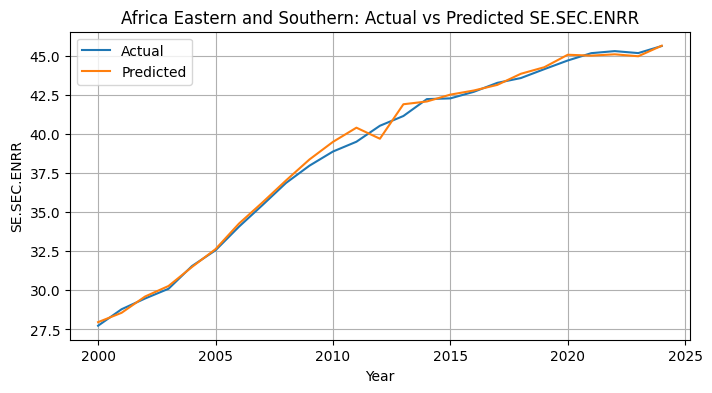

In [29]:

panel = panel.copy()
panel['pred'] = pipe.predict(X)

country_mae = (panel.assign(err=(panel[TARGET]-panel['pred']).abs())
               .groupby('country')['err'].mean()
               .sort_values())

print('Best-fit countries (lowest MAE):')
print(country_mae.head(10).round(2))
print('\nHardest-to-predict countries (highest MAE):')
print(country_mae.tail(10).round(2))

# Plot actual vs pred for a selected country
example_country = country_mae.index[0]
subset = panel[panel['country']==example_country].sort_values('year')
plt.figure(figsize=(8,4))
plt.plot(subset['year'], subset[TARGET], label='Actual')
plt.plot(subset['year'], subset['pred'], label='Predicted')
plt.title(f'{example_country}: Actual vs Predicted {TARGET}')
plt.xlabel('Year'); plt.ylabel(TARGET); plt.legend(); plt.grid(True); plt.show()


In [30]:

import joblib
art_path = MODELS / f'model_{TARGET}.joblib'
joblib.dump({'pipeline': pipe, 'features': num_cols + cat_cols, 'target': TARGET}, art_path)
print('Saved model to:', art_path)

# Also export a compact CSV of latest-year predictions for quick viewing
latest_pred = (panel.sort_values('year')
               .groupby('country_code')
               .tail(1)[['country','year', TARGET, 'pred']]
               .sort_values('country'))
csv_out = RAW / f'latest_{TARGET.replace(".","_")}_predictions.csv'
latest_pred.to_csv(csv_out, index=False)
print('Saved latest-year predictions to:', csv_out)
latest_pred.head()


Saved model to: /content/global-edu-dev/models/model_SE.SEC.ENRR.joblib
Saved latest-year predictions to: /content/global-edu-dev/data/raw/latest_SE_SEC_ENRR_predictions.csv


,country,year,SE.SEC.ENRR,pred
68,Afghanistan,2018,57.357849,57.703430
49,Africa Eastern and Southern,2024,45.606079,45.625740
99,Africa Western and Central,2024,46.300491,46.177040
149,Albania,2024,108.355392,105.071793
1524,Algeria,2024,105.164132,102.921013



## Notes & Next Steps
- Try different targets: set `TARGET` to another code in the configuration cell.
- Add time-aware validation: train up to year \(t\), test on \(t+1\) to evaluate forecasting.
- Consider panel fixed-effects regression (within estimator) for interpretable associations.
- Always interpret correlations with care — they do not imply causality.
